# Applying PCA to Image Compression

One application of Principal Component Analysis is compression due to its reduction of dimension. This could serve to decrease required storage space, bandwidth, or to eliminate random noise. We will be compressing images by first creating vector representations before applying the maximum variance forumulation of PCA.

These are the libraries we need to import. glob helps with file paths, numpy is useful for vector/matrix calculations, and matplotlib is useful for reading and showing images as well as plotting in general.

In [1]:
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import scipy.io as sci
import matplotlib.colors as colors

## Loading facial images (the boring stuff)

The images we will be working with are 192 by 168 pixels, which we can flatten to a one dimensional vector. These vectors are representations of the images, which can then be used in calculations like finding the average, eigenvectors, etc. Combining the vectors into a matrix will give us our data matrix $X = \{x_1, x_2, ... , x_n\}$, where $x_i$ is an image vector. We will store the vector values as unsigned 8 bit integers since pixel values take on values between 0 and 255. This is important to keep a note of when performing calculations, as overflow will return a value of enormous magnitude.

In [2]:
# dimensions of our bitmap images, need to be changed for a different data set
rows = 192
cols = 168

# get file paths before looping through and reading them all into vectors
img_files = glob.glob('yale_subset_719/*.bmp')
nimages = len(img_files)
imgs = np.zeros((rows * cols, nimages), dtype=np.uint8)
colseq = np.arange(nimages)
for i, picture in zip(colseq, img_files):
    imgs[:, i] = np.reshape(plt.imread(picture), (1, -1), order='F')

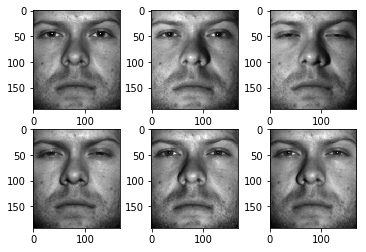

In [3]:
fig, axes = plt.subplots(2, 3)
count = 0
for i in np.arange(2):
    for j in np.arange(3):
        axes[i, j].imshow(np.reshape(imgs[:, count], (rows, -1), order='F'), cmap='gray')
        count = count + 1

We managed to print out the first 6 images properly! Another important note is that the reshape function needs to have Fortran style index ordering, which flattens the vector by column, in order to be compatible with matplotlib's imshow function. 

## Computing Eigenvectors/values (the fun stuff)

The maximum variance formulation of PCA maximizes the projected variance of the data points to our chosen principal subspace. Letting the basis vectors of the principal subspace be $\{u_1, u_2, ... , u_M\}$, where $u_i \in \mathbb{R}^D$, we can write the total projected variance as 

$$\frac{1}{N} \sum_{n=1}^{N} \sum_{i=1}^{M} \{u_i^Tx_n - u_i^T\bar{x}\}^2$$

which can be simplied to 

$$
\sum_{i=1}^{M} u_i^TSu_i, \text{where } S = \frac{1}{N} \sum_{n=1}^{N} (x_n - \bar{x})(x_n - \bar{x})^T
$$

Note that $S$ is the sample covariance. It can be proven that $\{u_1, u_2, ... , u_M\}$ are actually the eigenvectors of $S$, and choosing the $M$ eigenvectors that correspond to the $M$ greatest eigenvalues will maximize the projected variance. 

We will first calculate the "average" face by calculating the mean vector within $X$, before normalizing, calculating the sample covariance, and finding the $M$ greatest eigenvectors/values to compress an image with.

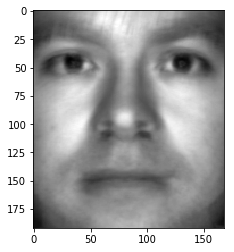

In [4]:
# calculate the average vector and print it out
avg_face = np.sum(imgs, axis=1) / nimages
avg_face.astype(np.uint8)
plt.imshow(np.reshape(avg_face, (rows, -1), order='F'), cmap='gray')

This is what the average face of our data set looks like. Not as terrifying as expected. 

Now we move on to computing $A = x_n - \bar{x}$ ,where $S=AA^T$, $S$ being our covariance matrix. Keep in mind that because our image vector is in uint8, we need to cast it and the average face vector to int16 to prevent overflow, perform our calculations, and cast back to uint8.

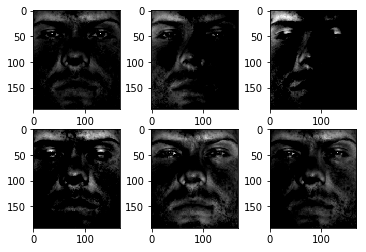

In [44]:
# cast all to int16 and subtract each image vector from the average before taking the outer product
A = np.zeros((rows * cols, nimages), dtype=np.int16)
for i in np.arange(nimages):
    A[:, i] = imgs[:, i].astype(np.int16) - avg_face.astype(np.int16)
    A[:, i][A[:, i] < 0] = 0
A.astype(np.uint8) 
    
fig, axes = plt.subplots(2, 3)
count = 0
for i in np.arange(2):
    for j in np.arange(3):
        axes[i, j].imshow(np.reshape(A[:, count], (rows, -1), order='F'), cmap='gray')
        count = count + 1

Here are the first 6 covariances, which correspond to the first 6 images shown above. Now this is more interesting, and can be thought of as a visualization of the deviation from the average face we constructed. 

Now we move on to computing the covariance matrix $S$, eigenvectors, and eigenvalues, which gets a bit harder to follow. For computational reasons, we will compute $A^TA$ rather than $AA^T$, as $AA^T$ has dimensions $32,256$ by $32,256$. The inner product is more or less like the outer product, but with some entries summed up. This time we cast our values to floating point ones, which lifts the restriction on the range of values we can compute because our eigenstuff need not be between 0 and 255.

In [46]:
# covariance matrix
S = np.matmul(A.T.astype(float), A.astype(float))
# D is eigenvalues, V is eigenvectors
D, V = np.linalg.eig(S)
# sort D, and then sort V the same way to get the eigenvectors in descending order
order = D.argsort()[::-1]
V = V[:, order]

# normalize U for output
U = np.matmul(A.astype(float), V)
squares = np.square(U)
denom = np.sqrt(np.sum(squares, axis=0))
for i in np.arange(nimages):
    U[:, i] = U[:, i] / denom[i]

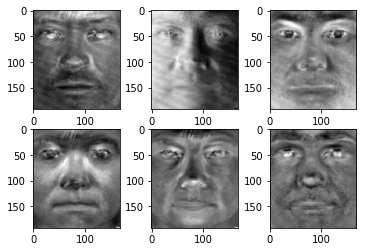

In [16]:
fig, axes = plt.subplots(2, 3)
count = 0
for i in np.arange(2):
    for j in np.arange(3):
        axes[i, j].imshow(np.reshape(U[:, count], (rows, -1), order='F'), cmap='gray')
        count = count + 1

These are the 6 largest eigenvectors(associated to the 6 largest eigenvalues). Quite terrifying. They do look humanoid though, for better or worse. These are the images we will use to construct the compressed image. 

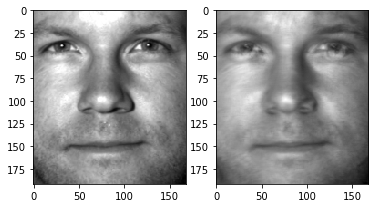

In [27]:
try_reconst = 50
n_eig = 7
omegas = np.matmul(U[:, 1:n_eig].T, (imgs[:, try_reconst].astype(float)) - avg_face)
res = np.matmul(U[:, 1:n_eig], omegas) + avg_face.astype(float)

fig, axes = plt.subplots(1,2)
axes[0].imshow(np.reshape(imgs[:, try_reconst], (rows, -1), order='F'), cmap='gray')
axes[1].imshow(np.reshape(res, (rows, -1), order='F'), cmap='gray')

Our compression basically blurs the image a bit, but keeps the more defining features so it's still recognizable. As we increase the number of eigenvectors used, the image will get more and more crisp until it matches the original. 

Plotting the eigenvalues, we can see that they decay rather quickly. This tells us that only the first several largest eigenvectors are essential to creating the maximum variance reconstruction, the rest have an exponential decaying contribution. 

Text(0,0.5,'eigenvalue')

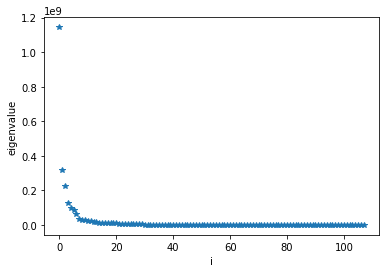

In [38]:
fig = plt.figure()
plt.plot(D, '*')
plt.xlabel('i')
plt.ylabel('eigenvalue')

The distortion, or error, of our reconstruction also decreases with more eigenvectors we use. This makes sense, as the quality of our reconstruction improves as we use more eigenvectors. This is another way to visualize the decay of our eigenvalue contributions. 

Text(0,0.5,'distortion')

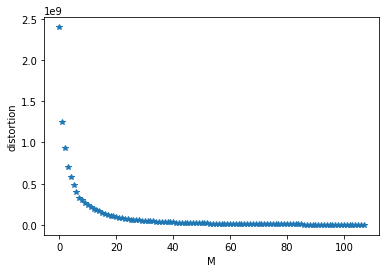

In [40]:
distortion = list()
for i in np.arange(len(D)):
    distortion.append(sum(D[i:]))
    
fig = plt.figure()
plt.plot(distortion, '*')
plt.xlabel('M')
plt.ylabel('distortion')